In [1]:
# Import necessary packages
# All transforms accept PIL images or tensor images

import numpy as np
import torch
from torchvision.datasets import VOCSegmentation
from torchvision.transforms.functional import to_tensor,to_pil_image
import torchvision.transforms as transforms
from PIL import Image

In [2]:
# Subclass the VOCSegmentation class(doc)

class myVOCSegmentation(VOCSegmentation):
    
    def __getitem__(self,index):
        img = Image.open(self.images[index]).convert('RGB')
        target = Image.open(self.masks[index])
        
        if self.transforms is not None:
            
            augmented = self.transforms(image=np.array(img),mask=np.array(target))
        
            img = augmented['image']
            target = augmented['mask'] 
            target[target>20]=0
        
        img = to_tensor(img) # to_tensor is used to convert PIL.Image/numpy.ndarray to Tensor
        target = torch.from_numpy(target).type(torch.long)
        
        return img, target

In [3]:
# Transformation Part
# Transforms are common image transformations. They can be chained together using Compose.

from albumentations import (HorizontalFlip,
                            Resize,
                            Compose,
                            Normalize)

h,w = 520, 520
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

# Normalization: image = (image - mean) / std

train_transformer = Compose([HorizontalFlip(p=0.5),
                           Resize(h,w),
                           Normalize(mean=mean,std=std)])

val_transformer = Compose([HorizontalFlip(p=0.5),
                           Resize(h,w)])

In [4]:
# load datasets

path2data = "./data/"
train_ds = myVOCSegmentation(path2data,
                             year="2012",
                             image_set="train",
                             download=True,
                             transforms=train_transformer)

val_ds = myVOCSegmentation(path2data,
                           year="2012",
                           image_set="val",
                           download=True,
                           transforms=val_transformer)

print(len(train_ds))
print(len(val_ds))

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
1464
1449


In [8]:
# show a sample of image and its groundtruth

from skimage.segmentation import mark_boundaries
import matplotlib.pylab as plt
%matplotlib inline  

In [9]:
num_classes = 21
np.random.seed(0)
COLORS = np.random.randint(0,2,size=(num_classes+1,3),dtype='uint8') # RGB tuple

In [10]:
def show_img_target(img,target):
    
    img = to_pil_image(img)
    target = target.numpy()
    
    for i in range(num_classes):
        
        mask = (target==i)
        # mark_boundaries return (M, N, 3) array of float
        img = mark_boundaries(np.array(img),
                              mask,
                              color=COLORS[i],
                              outline_color=COLORS[i])
        
    # plt.imshow(x),x can be array-like or PIL image
    # plt.imshow(img)
    return mask, img

In [13]:
def re_normalize(x,mean=mean,std=std):
    
    x_r = x.clone()
    
    for c, (mean_c, std_c) in enumerate(zip(mean,std)):
        x_r[c] = x_r[c]*std_c
        x_r[c] = x_r[c]+mean_c
    
    return x_r

In [12]:
img, mask = train_ds[6]
print(img.shape, img.type(), torch.max(img))
print(mask.shape, mask.type(),torch.max(mask))

torch.Size([3, 520, 520]) torch.FloatTensor tensor(2.6400)
torch.Size([520, 520]) torch.LongTensor tensor(4)


(520, 520)


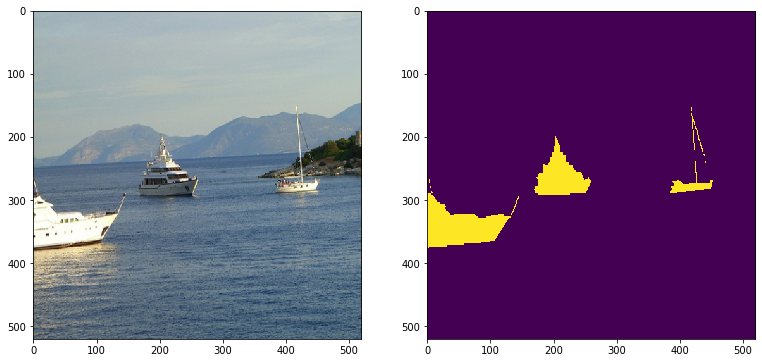

In [17]:
# Display
plt.figure(figsize=(20,20))

img_r = re_normalize(img)

plt.subplot(1,3,1)
plt.imshow(to_pil_image(img_r))
plt.subplot(1,3,2)
plt.imshow(mask)
#plt.subplot(1,3,3)
#show_img_target(img_r,mask)
a,b = show_img_target(img_r,mask)
print(a.shape)

In [5]:
# Define data loaders

from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds,batch_size=4,shuffle=True)
val_dl = DataLoader(val_ds,batch_size=8,shuffle=False)


In [17]:
 with torch.no_grad(): #希望该函数执行时省略梯度跟踪gradient tracking以减小内存消耗。Testing/Val惯例
        for i, batch in enumerate(train_dl):

            a, b = batch
            size = b.size()

In [18]:
print(size)

torch.Size([4, 520, 520])
